<a href="https://colab.research.google.com/github/ApoorvaNagarajan/Image-Filter-Kernels/blob/master/assignment13/assignment13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing all python packages**

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-emu1vabd
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-emu1vabd
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=21c504d2a703fc1b5dbca12c153bd501730cc269451b1df566715ee9c4dbbf52
  Stored in directory: /tmp/pip-ephem-wheel-cache-2nemgny7/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [3]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras.preprocessing import image
import cv2
from keras.callbacks import ModelCheckpoint
from keras_contrib.applications.resnet import ResNet18

Using TensorFlow backend.


# Load CIFAR10 dataset

In [4]:
# load CIFAR10 dataset
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


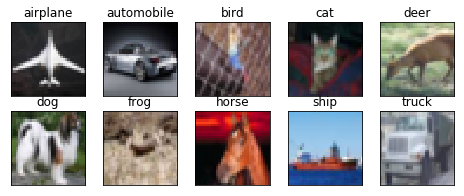

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
batch_sz = 128
num_classes = 10
weight_decay = 0.00005
numEpochs = 300

# Helper functions

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Cutout function used for image augmentation

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
class OneCycleLR(Callback):
    def __init__(self,
                 batch_size,
                 num_samples,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = None
        self.batch_size = batch_size
        self.samples = num_samples
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale
            #print('ending %d'%new_lr)

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale
            #new_lr = (self.initial_lr-0.01)/(self.mid_cycle_id-self.num_iterations)
            #new_lr = new_lr*(self.clr_iterations - self.mid_cycle_id) + 1
            #print('down %d'%new_lr)

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            #print(current_percentage)
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale
            #new_lr = (self.initial_lr-0.01)/(self.mid_cycle_id-1)
            #new_lr = new_lr*(self.clr_iterations - self.mid_cycle_id) + 1
            #print('starting %f'%new_lr)

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        self.epochs = self.params['epochs']
        #self.batch_size = self.params['batch_size']
        #self.samples = self.params['samples']
        self.steps = self.params['steps']

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))

# Preprocessing

**Pixel normalization**

In [0]:
# pixel normalization
train_X = train_features.astype('float32')/255
test_X = test_features.astype('float32')/255

# convert class labels to binary class labels
train_Y = np_utils.to_categorical(train_labels, num_classes)
test_Y = np_utils.to_categorical(test_labels, num_classes)

**Image Normalization**

In [12]:
# normalization values (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

#mean = np.array([0.4914, 0.4822, 0.4465])
#std_dev = np.array([0.2023, 0.1994, 0.2010])

mean = np.mean(train_X, axis=(0,1,2))
std_dev = np.std(train_X, axis=(0,1,2))

normalize = lambda x: ((x - mean) / std_dev)

train_X = normalize(train_X)
test_X = normalize(test_X)

print(test_X.shape)

(10000, 32, 32, 3)


**Padding to make the mage 40x40**

In [0]:
pad4 = lambda x: np.pad(x, [(4, 4), (4, 4), (0, 0)], mode='edge')

#train_X = pad4(train_X)

#print(train_X.shape)

**Image Augmentation: Cutout**

In [0]:
eraser = get_random_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, v_l=0, v_h=1, pixel_level=True)


def pre_proc(img):
  
    #Pad to 40x40
    padImg = pad4(img)

    # crop the image
    height, width = padImg.shape[0], padImg.shape[1]
    dx, dy = img.shape[0], img.shape[1]
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    cropImg = padImg[y:(y+dy), x:(x+dx), :]
    
    #random erase
    randErase = eraser(cropImg)
    
    #filp left and right randomly
    flip = np.random.randint(0,1)
    if(flip == 1):
      randErase = np.fliplr(randErase)
      
    return randErase



datagen = ImageDataGenerator(preprocessing_function=pre_proc)

#train_iterator = datagen.flow(train_X, train_Y, batch_size=batch_sz,shuffle=False)

#X_e, Y_e = train_iterator.next()

#fig = plt.figure(figsize=(8,3))
#for i in range(10):
#    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
#    im = X_e[i]
#    plt.imshow(im)
#plt.show()

# Model

In [15]:
model = ResNet18((32,32,3), num_classes)

W0818 04:24:47.055618 140063634163584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 04:24:47.096158 140063634163584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 04:24:47.104822 140063634163584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0818 04:24:47.155886 140063634163584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0818 04:24:47.157033

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


# Train model

W0818 04:24:54.564460 140063634163584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=390.625, validation_data=(array([[[..., callbacks=[<__main__..., verbose=1, epochs=300)`
  del sys.path

390.625


W0818 04:24:55.208814 140063634163584 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/300
391/390 [==============================] - 37s 95ms/step - loss: 2.9262 - acc: 0.3396 - val_loss: 15.0242 - val_acc: 0.1010
 - lr: 0.05333 - momentum: 0.95 

Epoch 00001: val_acc improved from -inf to 0.10100, saving model to assign13
Epoch 2/300
391/390 [==============================] - 30s 77ms/step - loss: 2.9092 - acc: 0.3380 - val_loss: 2.5770 - val_acc: 0.4092
 - lr: 0.05666 - momentum: 0.95 

Epoch 00002: val_acc improved from 0.10100 to 0.40920, saving model to assign13
Epoch 3/300
391/390 [==============================] - 30s 77ms/step - loss: 2.4334 - acc: 0.4245 - val_loss: 2.2203 - val_acc: 0.4789
 - lr: 0.06000 - momentum: 0.95 

Epoch 00003: val_acc improved from 0.40920 to 0.47890, saving model to assign13
Epoch 4/300
391/390 [==============================] - 30s 77ms/step - loss: 2.1568 - acc: 0.4760 - val_loss: 1.9321 - val_acc: 0.5418
 - lr: 0.06334 - momentum: 0.95 

Epoch 00004: val_acc improved from 0.47890 to 0.54180, saving model to assign13
Epoch 

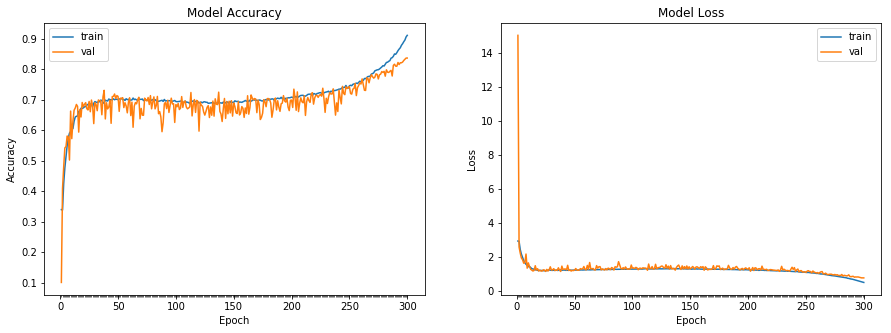

Accuracy on test data is: 83.65


In [16]:
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


lr_manager = OneCycleLR(batch_size=batch_sz, num_samples=train_X.shape[0], max_lr=0.5, end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=0.95, minimum_momentum=0.85)
checkpoint = ModelCheckpoint("assign13",verbose=1,save_best_only=True, monitor='val_acc', mode='max')

print(train_X.shape[0]/batch_sz)

start = time.time()
model_info = model.fit_generator(datagen.flow(train_X, train_Y, batch_size = batch_sz, shuffle=True),
                                 steps_per_epoch = train_X.shape[0]/batch_sz, nb_epoch = 300, 
                                 validation_data = (test_X, test_Y), callbacks=[lr_manager , checkpoint], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))


# plot model history
plot_model_history(model_info)

# compute test accuracy
model.load_weights("assign13")
print ("Accuracy on test data is: %0.2f"%accuracy(test_X, test_Y, model))